# <center>Прогноз оттока клиентов из телеком-компании</center>
<center> Автор: Роман Сарычев

In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.learning_curve import validation_curve
from sklearn.learning_curve import learning_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


**[Данные](https://bigml.com/user/francisco/gallery/dataset/5163ad540c0b5e5b22000383) по оттоку клиентов в телком-компании.**

In [2]:
# Чтение файла
df = pd.read_csv('../../data/telecom_churn.csv')

### <center>Описание набора данных и признаков</center>

In [3]:
# Проверка, что файл прочитался нормально
df.head().T

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


Каждая строка представляет собой одного клиента - это **объект** исследования.  
Столбцы - **признаки** объекта.


Описание признаков объекта:  
**State** - Буквенный код штата, номинальный признак  
**Account length** - Общее время, в течение которого клиент обслуживается компанией, количественный признак  
**Area code** - Префикс номера телефона, количественный признак   
**International plan** - Международный роуминг, бинарный признак (подключен/не подключен)  
**Voice mail plan** - Голосовая почта, бинарный признак (подключена/не подключена)  
**Number vmail messages** - Количество голосовых сообщений, количественный признак  
**Total day minutes** - Общая длительность разговоров днем, количественный признак  
**Total day calls** - Общее количество звонков днем, количественный признак  
**Total day charge** - Общая сумма оплаты за услуги днем, количественный признак  
**Total eve minutes** - Общая длительность разговоров вечером, количественный признак  
**Total eve calls** - Общее количество звонков вечером, количественный признак  
**Total eve charge** - Общая сумма оплаты за услуги вечером, количественный признак  
**Total night minutes** - Общая длительность разговоров ночью, количественный признак  
**Total night calls** - Общее количество звонков ночью, количественный признак  
**Total night charge** - Общая сумма оплаты за услуги ночью, количественный признак  
**Total intl minutes** - Общая длительность международных разговоров, количественный признак  
**Total intl calls** - Общее количество  международных разговоров, количественный признак  
**Total intl charge** -  Общая сумма оплаты за международные разговоры, количественный   признак  
**Customer service calls** - Количество обращений в сервисный центр, количественный признак 
  
Целевая переменная: **Churn** - Признак оттока, бинарный признак (1 - потеря клиента, то есть отток)  

### <center>Описание предобработки данных</center>

In [4]:
# Тип данных признаков 'International plan' и 'Voice mail plan' - объекты,
# нужно преобразовать  в булевый тип.
obj_cols = ['International plan', 'Voice mail plan']
df[obj_cols] = df[obj_cols] == 'Yes'

In [5]:
# Преобразование номинального признака названия штата в количественный
state_encoder = preprocessing.LabelEncoder()
state_encoder.fit(df['State'])
df['State'] = state_encoder.transform(df['State']).astype("float64")

###  <center>Первичный анализ признаков</center>

In [6]:
#Просмотр типов данных
df.info()

# Все данные заполнены, пропусков нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
State                     3333 non-null float64
Account length            3333 non-null int64
Area code                 3333 non-null int64
International plan        3333 non-null bool
Voice mail plan           3333 non-null bool
Number vmail messages     3333 non-null int64
Total day minutes         3333 non-null float64
Total day calls           3333 non-null int64
Total day charge          3333 non-null float64
Total eve minutes         3333 non-null float64
Total eve calls           3333 non-null int64
Total eve charge          3333 non-null float64
Total night minutes       3333 non-null float64
Total night calls         3333 non-null int64
Total night charge        3333 non-null float64
Total intl minutes        3333 non-null float64
Total intl calls          3333 non-null int64
Total intl charge         3333 non-null float64
Customer service calls    3333 non-null int64
Chu

In [7]:
# Смотрим на статистические характеристики:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
State,3333.0,26.059406,14.824911,0.00,14.00,26.00,39.00,50.00
Account length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
Area code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
Number vmail messages,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
Total day minutes,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
Total day calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
Total day charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
Total eve minutes,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
Total eve calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
Total eve charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91


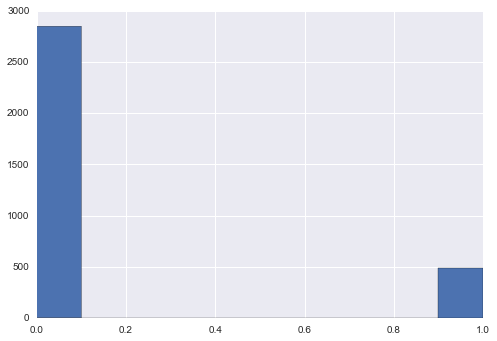

In [8]:
# Распределение целевой переменной
df['Churn'].hist()

In [9]:
df['Churn'].value_counts()

False    2850
True      483
Name: Churn, dtype: int64

Выборка не сбалансированна, одного класса больше чем другого.

### <center>Первичный визуальный анализ признаков </center>

In [10]:
# Анализируемые признаки (переменная создана для удобства предварительного анализа)
predictors = [
#  'State',
 'Account length',
#  'Area code',
# 'International plan',
# 'Voice mail plan',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
#  'Churn'
]

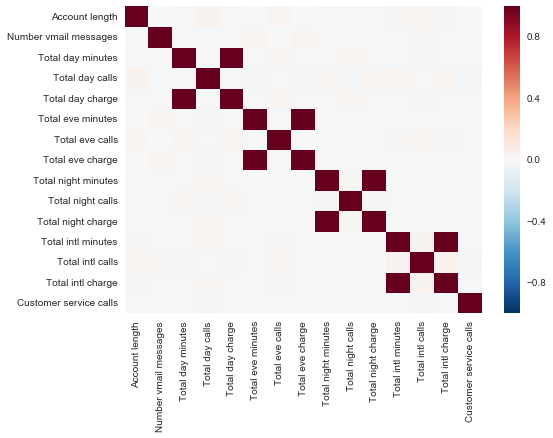

In [11]:
# Ищем коррелирующие признаки
corr = df[predictors].corr()
sns.heatmap(corr)

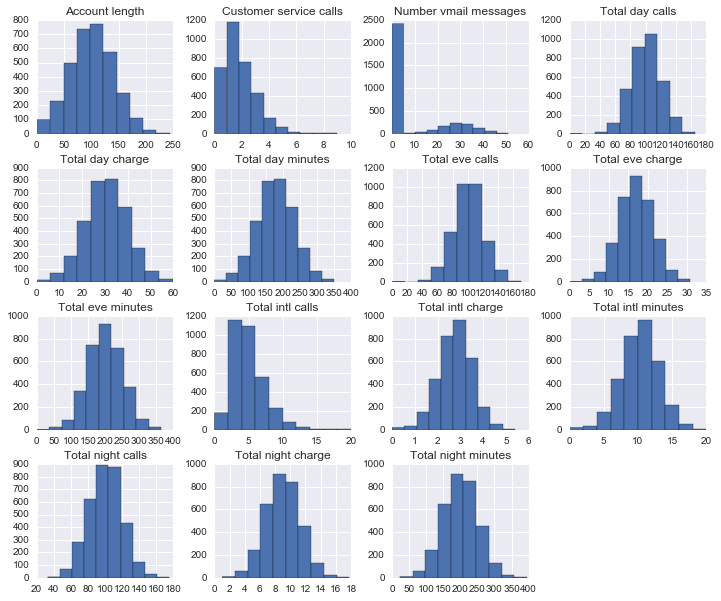

In [12]:
# Строим графики распределения признаков
plots = df[predictors].hist(figsize=(12,10))

### <center>Закономерности:</center>
1. На первый взгляд величина среднего количества звонков в разное время суток наблюдается на одном уровне, средняя продолжительность звонков вечером и ночью в среднем все-таки больше. Это соответствует действительности и логично, поскольку люди чаще совершают продолжительные звонки в свободное от работы и учебы время, а днем большинство совершаются кратковременные деловые звонки.
2. Несмотря на то что средняя продолжительность разговоров увеличивается по мере смены времени суток (вечером и ночью больше, чем днем), мы можем наблюдать, что среднее количество звонков остается на прежнем уровне. Но при этом сумма оплаты разговоров снижается, что, вероятно, связанно с повременным тарифом, т.е. в разное время суток, разная тарификация.
3. Средняя продолжительность международных звонков небольшая. Это связанно с дорогими тарифами на роуминг.

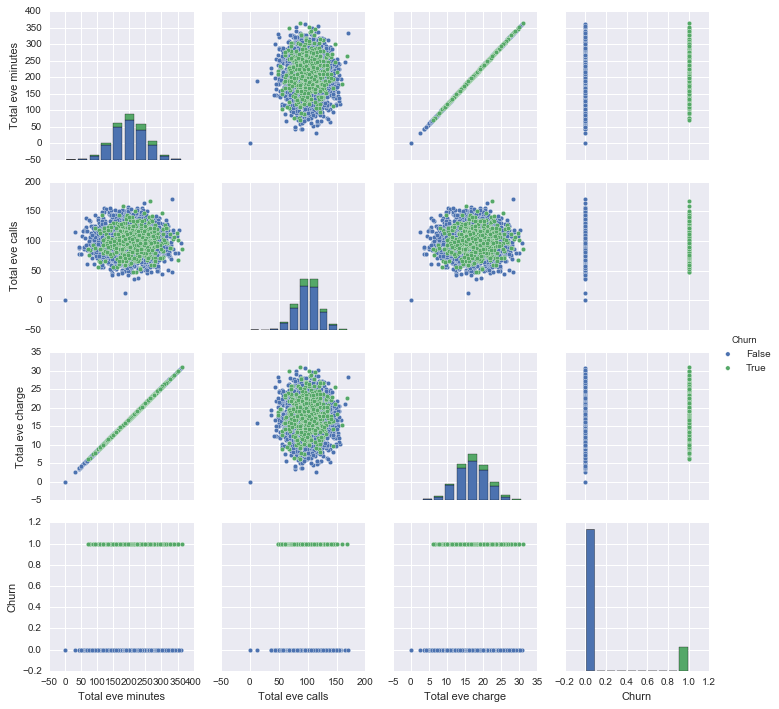

In [13]:
# Пробуем найти влияние количества звонков, общей продолжительности и суммы оплаты.
# Берем вечерний период, так как он самый активный. 
sns.pairplot(df[['Total eve minutes', 'Total eve calls', 'Total eve charge',
                 'Churn']], hue='Churn')

# Зависимости не выявлено, отток клиентов по этим параметрам равномерен.
# Наблюдается линейная зависимость суммы оплаты от общей продолжительности разговоров.

Основываясь на экспертном мнении, можно предположить, что на отток клиента может сильно влиять общее время обслуживания клиента и количество обращений в сервисный центр. Пробуем выявить зависимость.

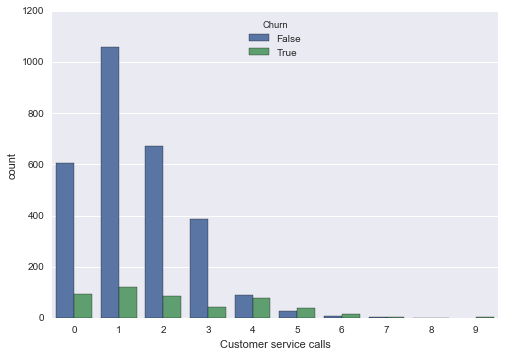

In [14]:
# Зависимость признака оттока от количества обращений в сервисный центр
sns.countplot(x='Customer service calls', hue="Churn", data=df)

Подсчитаем долю вышедших в отток клиентов от не вышедших и
долю вышедших в отток от суммы всех клиентов в определенном количестве звонков.

Построим линейные графики.

In [15]:
true_service_calls = df[df['Churn'] == True].groupby('Customer service calls')['Churn'].count()
false_service_calls = df[df['Churn'] == False].groupby('Customer service calls')['Churn'].count()
ratio = true_service_calls / false_service_calls * 100
ratio_all = true_service_calls / (true_service_calls + false_service_calls) * 100

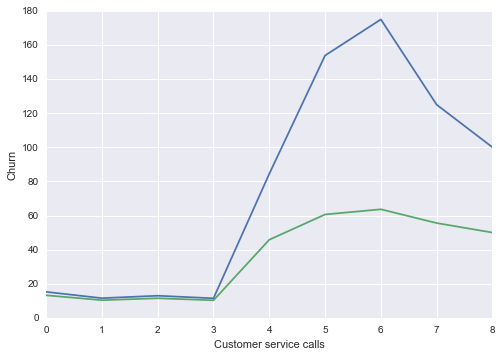

In [16]:
plt.plot(ratio)
plt.plot(ratio_all)
plt.xlabel('Customer service calls')
plt.ylabel('Churn')
plt.show()

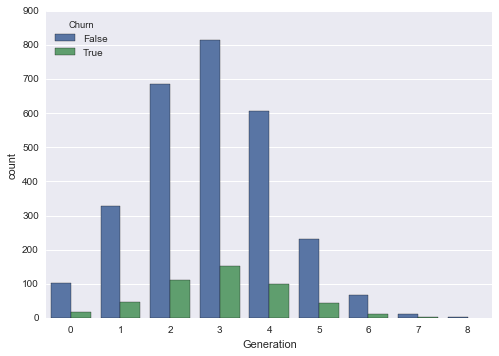

In [17]:
# Так как продолжительность является количественным и непрерывным признаком,
# то для упрощения визуализации разделим клиентов на несколько 'поколений'.
df['Generation'] = df['Account length'].apply(lambda x: x//30)
sns.countplot(x='Generation', hue="Churn", data=df)

Подсчитаем доли вышедших в отток клиентов от не вышедших и
долю вышедших в отток от суммы всех клиентов по поколениям.

Построим линейные графики.

In [18]:
true_generation = df[df['Churn'] == True].groupby('Generation')['Churn'].count()
false_generation = df[df['Churn'] == False].groupby('Generation')['Churn'].count()
ratio = true_generation / false_generation * 100
ratio_all = true_generation / (true_generation + false_generation) * 100

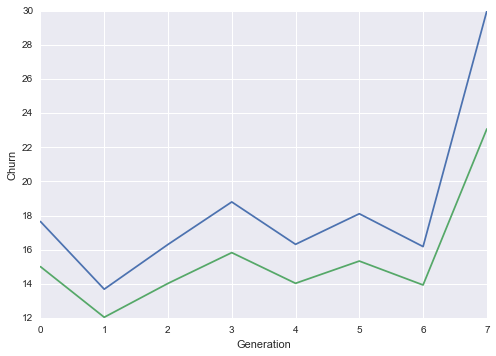

In [19]:
plt.plot(ratio)
plt.plot(ratio_all)
plt.xlabel('Generation')
plt.ylabel('Churn')
plt.show()

### <center>Инсайты:</center>
1. Клиенты, совершающие более 3-х звонков в call-центр, имеют разительно  более высокий процент оттока, Это может быть обусловлено тем, что большое кол-во звонков объясняется существованием серьезных проблем у звонящих клиентов, что сильно повышает вероятность их попадания в отток.  
В случаях с меньшим количеством звонков, чем 3, процент оттока остается стабильным на достаточно низком уровне (10%-15%), что подтверждает приведенную выше гипотезу.
2. Анализ единиц продолжительности жизни клиента показал, что увеличение данного показателя ведет к более интенсивному оттоку клиентов. 
Данная закономерность ожидаема и может говорить о том, что рассматриваемый клиентский продукт подвержен изменениям "моды".  
C шестого этапа жизни (из выделенных периодов в 30 единиц), заметно значительное увеличение интенсивности оттока.  
Это может быть обусловлено тем, что на этот момент клиент приобретает определенное отрицательное благо, либо теряет положительное.  
Например, теряет льготные условия обслуживания, которые предоставлялись ему в течение 6 этапов и т. п. 



### <center>Создание новых признаков</center>

Звонки по телефону - это целевая услуга, которая предоставляется абоненту,
поэтому пробуем рассчитать, сколько стоит гипотетическая "минута" (то есть без учета других услуг) разговора у абонента.

In [20]:
df['Cost of Minute'] = (df['Total day charge'] + 
                        df['Total eve charge'] +
                        df['Total night charge'] +
                        df['Total intl charge']) / (df['Total day minutes'] + 
                                                    df['Total eve minutes'] +
                                                    df['Total night minutes'] +
                                                    df['Total intl minutes'])

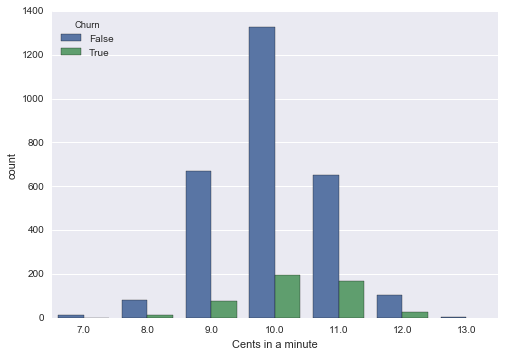

In [21]:
# Визуальный анализ нового признака
df['round'] = df['Cost of Minute'].apply(lambda x: round(x, 2) * 100)
sns.countplot(x='round', hue="Churn", data=df)
plt.xlabel('Cents in a minute')

In [22]:
true_generation = df[df['Churn'] == True].groupby('round')['Churn'].count()
false_generation = df[df['Churn'] == False].groupby('round')['Churn'].count()
ratio = true_generation / false_generation * 100
ratio_all = true_generation / (true_generation + false_generation) * 100

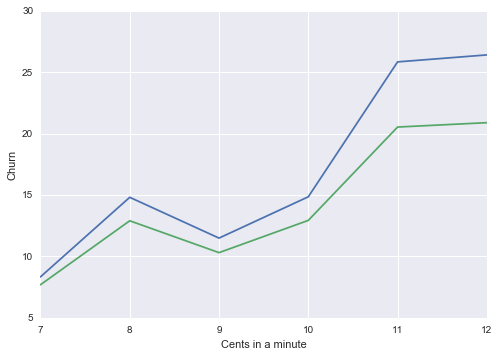

In [23]:
plt.plot(ratio)
plt.plot(ratio_all)
plt.xlabel('Cents in a minute')
plt.ylabel('Churn')
plt.show()

Анализ стоимости "минуты" показывает, что признак имеет важное значение.
При стоимости минуты больше 10 центов, вероятность попадания абонента в отток возрастает,
а при стоимости менее 7 центов за минуту - вероятность очень мала.

### <center>Отбор признаков</center>

In [24]:
# Маштабируем переменные и конвертируем назад в Pandas DataFrame
df_scale = preprocessing.scale(df)
df_scale = pd.DataFrame(df_scale)
df_scale.columns = df.columns

Для оценки важности признаков сделаем предсказание случайного леса с параметрами по умолчанию. Вместо кросс-валидации будем использовать Out-of-Bag оценку.

In [25]:
# Выделим обучающую выборку и целевую переменую 
X, y = df[[s for s in df_scale.columns if s != 'Churn']], df['Churn']

In [27]:
first_forest = RandomForestClassifier(n_estimators=1000, max_depth = 5, 
                                      oob_score=True, n_jobs=-1,
                                      random_state=42).fit(X, y)

In [28]:
# Посмотрим точность предсказания
first_forest.oob_score_

0.89498949894989499

In [29]:
first_forest_predictions = first_forest.predict(X)
features = pd.DataFrame(first_forest.feature_importances_, index=X.columns,
                        columns=['Importance']).sort(['Importance'], ascending=False)
features

,Importance
Total day charge,0.184386
Total day minutes,0.181803
Customer service calls,0.144044
International plan,0.107061
Total eve minutes,0.047069
Total eve charge,0.047064
Cost of Minute,0.035339
Number vmail messages,0.033886
Total intl calls,0.032222
Total intl minutes,0.031090


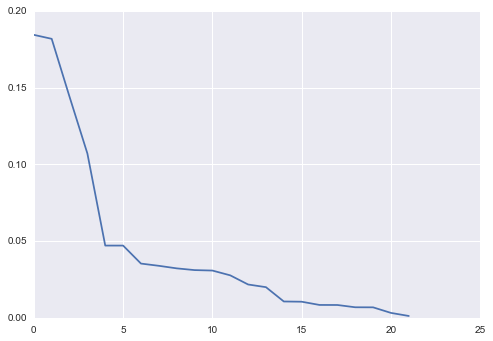

In [30]:
# Кривая оценок важности признаков
plt.plot(range(len(features.Importance.tolist())), 
         features.Importance.tolist())

Анализируя оценки важности можно сделать следующие выводы:
1. Ожидаемо вспомогаемые признаки Generation и round имеют малый вес. Также ожидаемо, что код штата и префикс номера имеют малый вес. Эти признаки не будут использоваться в обучающей выборке.
2. Показатели активности абонента с маленькими значениями, например: Account length, Total day calls и другие, все же могут вносить незначительные коррективы, поэтому удалятся не будут.

In [31]:
X = df[['Total day charge',
        'Total day minutes',
        'Customer service calls',
        'International plan',
        'Total eve minutes',
        'Total eve charge',
        'Cost of Minute',
        'Number vmail messages',
        'Total intl calls',
        'Total intl minutes',
        'Voice mail plan',
        'Total intl charge',
        'Total night minutes',
        'Total night charge',
        'Total day calls',
        'Total night calls',
        'Account length',
        'Total eve calls']]

### <center>Построение модели классификации</center>

In [32]:
# Разбиваем на тестовую и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Попробуем четыре разных классификатора: логистическую регрессию, метод ближайших соседей, Gradient boosting, Random Forest и SVM. Так как у нас сильный дисбаланс в выборке, то в качестве меры будем использовать F1 score.

In [33]:
classifiers = [LogisticRegression(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(), 
               RandomForestClassifier(), 
               SVC()]
classifiers_name = ['LogisticRegression',
                    'KNeighborsClassifier',
                    'GradientBoostingClassifier', 
                    'RandomForestClassifier', 
                    'SVC']

In [34]:
# Настройка параметров выбранных алгоритмов с помощью GridSearchCV 
n_folds = 5
scores = []
fits = []
logistic_params = {'penalty': ('l1', 'l2'),
                   'C': (.01,.1,1,5)}
knn_params = {'n_neighbors': list(range(3, 12, 2))}
gbm_params = {'n_estimators': [100, 300, 500],
              'learning_rate':(0.1, 0.5, 1),
              'max_depth': list(range(3, 6)), 
              'min_samples_leaf': list(range(10, 31, 10))}
forest_params = {'n_estimators': [100, 300, 500],
                 'criterion': ('gini', 'entropy'), 
                 'max_depth': list(range(3, 6)), 
                 'min_samples_leaf': list(range(10, 31, 10))}

svm_param = {'kernel' : ('linear', 'rbf'), 'C': (.5, 1, 2)}
params = [logistic_params, knn_params, gbm_params, forest_params, svm_param]

### <center>Кросс-валидация</center>

In [ ]:
for i, each_classifier in enumerate(classifiers):
    clf = each_classifier
    clf_params = params[i]
    grid = GridSearchCV(clf, clf_params, 
                        cv=StratifiedKFold(y_train, n_folds=n_folds,
                        shuffle=False, random_state=42), 
                        n_jobs=-1, scoring="f1")
    grid.fit(X_train, y_train)
    fits.append(grid.best_params_)
    clf_best_score = grid.best_score_
    scores.append(clf_best_score)
    print(classifiers_name[i], clf_best_score, "\n", grid.best_params_, "\n")

In [37]:
grid_value = max(scores)
grid_index = [i for i in range(len(scores)) if scores[i]==grid_value][0]
print("Лучший классификатор при GridSearch:",
      classifiers_name[grid_index], grid_value)
print(fits[grid_index])

Лучший классификатор при GridSearch: GradientBoostingClassifier 0.830606228508
{'max_depth': 4, 'learning_rate': 0.1, 'min_samples_leaf': 10, 'n_estimators': 300}


In [38]:
clf_params = {'n_estimators': (300, 350, 400), 
              'learning_rate': (0.1, 0.3, 0.5, 0.75, 1), 
              'min_samples_leaf': list(range(1, 14, 3))}

clf = classifiers[grid_index]
grid = GridSearchCV(clf, clf_params, cv=n_folds, 
                    n_jobs=-1, scoring="f1")
grid.fit(X_train, y_train)
clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
clf_best = grid.best_estimator_
mean_validation_scores = []
print("Лучший результат", clf_best_score, 
      "лучшие параметры", clf_best_params)

Лучший результат 0.825307154892 лучшие параметры {'learning_rate': 0.3, 'min_samples_leaf': 4, 'n_estimators': 400}


### <center>Построение кривых валидации и обучения</center>

In [45]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

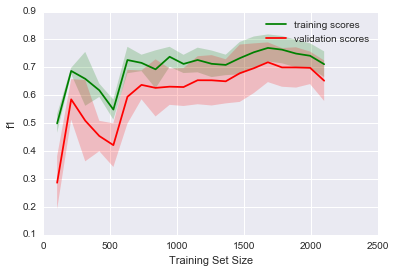

In [44]:
# Кривая обучения
plot_learning_curve(GradientBoostingClassifier(n_estimators=2, 
                    learning_rate=1.5, min_samples_leaf=7),
                   X_train, y_train, scoring='f1', cv=10)

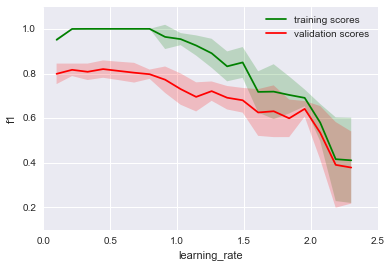

In [46]:
# Кривая валидации
learning_rates = np.linspace(0.1, 2.3, 20)
plot_validation_curve(GradientBoostingClassifier(n_estimators=250, 
                    min_samples_leaf=7), X_train, y_train, 
                    cv_param_name='learning_rate', 
                    cv_param_values=learning_rates,
                    scoring='f1')

### <center>Финальный прогноз для отложенной выборки</center>

In [50]:
final_gbm = GradientBoostingClassifier(n_estimators=300, 
                    min_samples_leaf=10, learning_rate=0.1, max_depth=4)
final_gbm.fit(X_train, y_train)
final_pred = final_gbm.predict(X_test)
accuracy_score(y_test, final_pred), f1_score(y_test, final_pred)

(0.95899999999999996, 0.82403433476394838)

### <center>Оценка модели с описанием выбранной метрики</center>

Построена модель предсказания, уйдет ли абонент телеком-копмании в отток. Модель предсказывает с 96%-ной долей правильных ответов на отложенных 30% выборки. Но accuracy не очень хорошо характеризует качество модели из-за сильного дисбаланса в целевой переменной (~85% против ~15%), поэтому в качестве целевой была выбрана метрика F1-score. На отложенной выборке удалось добиться хорошего результата F1=0.82. Построены кривые обучения и валидационные кривые. Видно, что увеличение количества примеров более 1700 не приносит существенной выгоды (у нас в обучающей выборке более 3000 примеров).

## <center>Общие выводы</center>

По результатам проведенного анализа, можно увидеть, что есть определенные зависимости и признаки показателя оттока. 
Наблюдаются определенные закономерности - продолжительность звонков в определенное время суток, международные звонки, сумма оплаты разговоров. 
Имеет влияние количество обращений клиентами в сервисный центр - совершающие более 3-х звонков с большей вероятностью попадут в отток. 
Также прямое отношение в показателю оттока имеет срок жизни клиента - клиенты со сроком жизни более 6-ти отрезков времени по 30 единиц имеют больший риск попасть в отток. 
Выявленным признаком оттока является стоимость минуты разговора клиента - минимальная вероятность попадания клиента в отток наблюдается при стоимости минуты разговора клиента при 7 центах. С наибольшей вероятностью клиент покинет компанию при стоимости в 10 центов и более.